In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from pykalman import KalmanFilter

In [2]:
# load time series
AUD = pd.read_csv("../data/AUD.csv")
EUR = pd.read_csv("../data/EUR.csv")
GBP = pd.read_csv("../data/GBP.csv")
NZD = pd.read_csv("../data/NZD.csv")

In [3]:
NZD.head()

,Date,Price
0,32874,0.5955
1,32875,0.5962
2,32876,0.5958
3,32877,0.6002
4,32878,0.5995


In [4]:
df = AUD.merge(EUR,on='Date').merge(GBP,on='Date').merge(NZD,on='Date')
df.columns = ["Date", "AUD", "EUR", "GBP", "NZD"]

In [5]:
prices_df = df[["AUD", "EUR", "GBP", "NZD"]]

# Pairs selection & Cointegration test

In [6]:
def find_cointegrated_pairs(dataframe):
    # 得到DataFrame长度
    n = dataframe.shape[1]
    # 初始化p值矩阵
    pvalue_matrix = np.ones((n, n))
    # 抽取列的名称
    keys = dataframe.keys()
    # 初始化强协整组
    pairs = []
    # 对于每一个i
    for i in range(n):
        # 对于大于i的j
        for j in range(i+1, n):
            # 获取相应的两只股票的价格Series
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            # 分析它们的协整关系
            result = sm.tsa.stattools.coint(stock1, stock2)
            # 取出并记录p值
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            # 如果p值小于0.05
            if pvalue < 0.05:
                # 记录股票对和相应的p值
                pairs.append((keys[i], keys[j], pvalue))
    # 返回结果
    return pvalue_matrix, pairs

In [7]:
pvalues, pairs = find_cointegrated_pairs(prices_df)

In [8]:
stock_list = ["AUD", "EUR", "GBP", "NZD"]

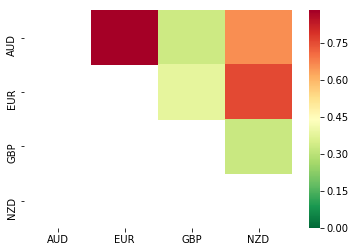

In [9]:
sns.heatmap(1-pvalues, xticklabels=stock_list, yticklabels=stock_list, cmap='RdYlGn_r', mask = (pvalues == 1))
plt.show()

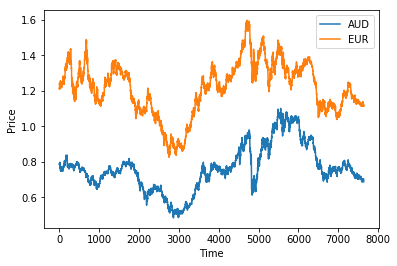

In [10]:
stock_df1 = prices_df["AUD"]
stock_df2 = prices_df["EUR"]
plt.plot(stock_df1)
plt.plot(stock_df2)
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(["AUD", "EUR"],loc='best')
plt.show()

In [11]:
X = np.array(stock_df1).reshape(-1,1)
y = np.array(stock_df2)
reg = LinearRegression().fit(X, y)
gamma = reg.coef_
u = reg.intercept_
print("r square:", reg.score(X, y))
print("gamma:{}".format(gamma))
print("mu:{}".format(u))

r square: 0.5900400062511548
gamma:[0.88639246]
mu:0.5384269900960108


In [12]:
# method2 for regression
x = stock_df1
y = stock_df2
X = sm.add_constant(x)
result = (sm.OLS(y,X)).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    EUR   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                 1.100e+04
Date:                Mon, 12 Aug 2019   Prob (F-statistic):               0.00
Time:                        00:47:44   Log-Likelihood:                 7095.9
No. Observations:                7643   AIC:                        -1.419e+04
Df Residuals:                    7641   BIC:                        -1.417e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5384      0.007     82.303      0.0

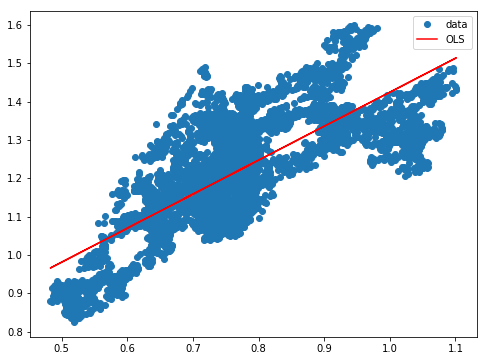

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="data")
ax.plot(x, result.fittedvalues, 'r', label="OLS")
ax.legend(loc='best')
plt.show()

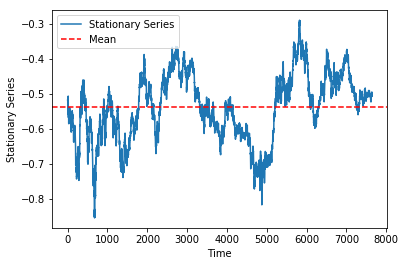

In [14]:
plt.plot(0.8864*stock_df1-stock_df2);
plt.axhline((0.8864*stock_df1-stock_df2).mean(), color="red", linestyle="--")
plt.xlabel("Time"); plt.ylabel("Stationary Series")
plt.legend(["Stationary Series", "Mean"])
plt.show()

# tests for the stationarity of $\hat{\epsilon_t}$ (Augmented Dickey-Fuller test)

In [15]:
e = prices_df["EUR"] - prices_df["AUD"]*gamma+u

In [16]:
result = adfuller(e)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.252907
p-value: 0.017119
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# Trading strategy design - baseline

In [17]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [31]:
z = prices_df["EUR"] - prices_df["AUD"]*gamma

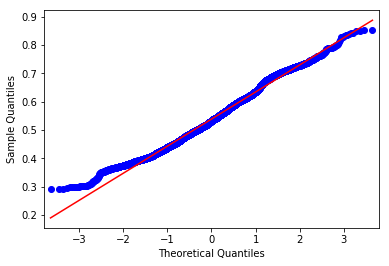

In [32]:
# spread normal dist.?
qqplot(z, line='s')
plt.show()

### z-score method (standard normalizatoin)

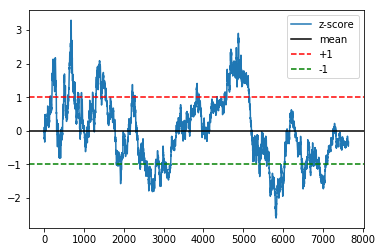

In [33]:
z_zscore = zscore(z)
plt.plot(zscore(z))
plt.axhline(zscore(z).mean(), color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["z-score", "mean", "+1", "-1"])
plt.show()

Total profit = profit of each trade × number of trades
* profit of each trade is $s_0$
* number of trades is related to the zero crossings, which can be analyzed theoretically as well as empirically.

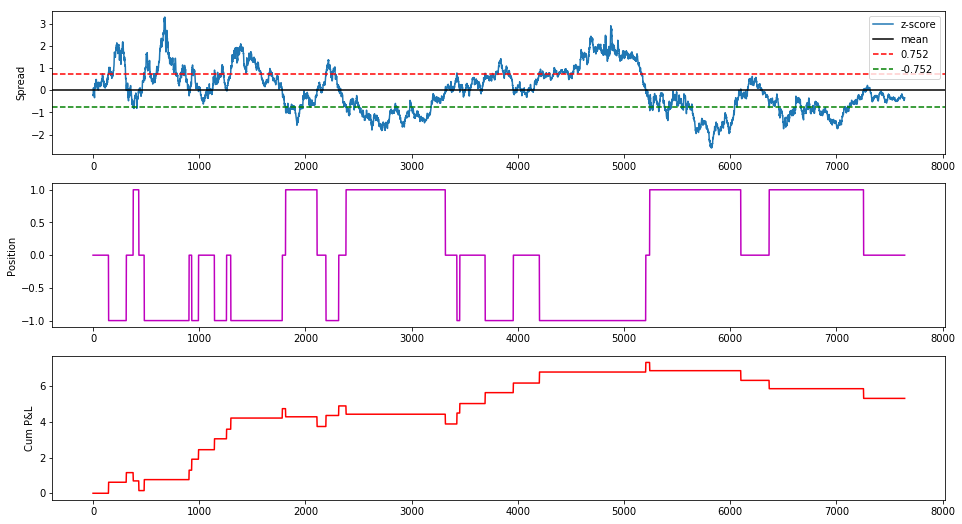

In [34]:
S = np.arange(0.0, 3.0, 0.001)
prob = 1-norm.cdf(S, scale=1)
total_profit = S*len(prices_df["EUR"])*(1-norm.cdf(S)) # use standard normal
s0 = S[np.argmax(total_profit)]

spread = -prices_df["EUR"] + prices_df["AUD"]*gamma
profit = [0]*len(z_zscore)
cum_profit = 0
position = [0]*len(z_zscore)
cur_pos = 0
for i in range(1, len(z_zscore)):
    
    if z_zscore[i]<-s0 and cur_pos==0:
        # buy spread
        cum_profit += spread[i]
        cur_pos = 1
    if z_zscore[i]>s0 and cur_pos==0:
        # short-sell spread
        cum_profit -= spread[i]
        cur_pos = -1
    if z_zscore[i]*z_zscore[i-1]<0 and cur_pos==-1: # zero-crossing
        cum_profit -= spread[i]
        cur_pos = 0
    if z_zscore[i]*z_zscore[i-1]<0 and cur_pos==1:
        cum_profit += spread[i]
        cur_pos = 0
        
    profit[i] = cum_profit
    position[i] = cur_pos

plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
z_zscore = zscore(z)
plt.plot(zscore(z))
plt.axhline(zscore(z).mean(), color="black")
plt.axhline(s0, color="red", linestyle="--")
plt.axhline(-s0, color="green", linestyle="--")
plt.legend(["z-score", "mean", "{}".format(s0), "{}".format(-s0)])
plt.ylabel("Spread")

plt.subplot(3,1,2)
plt.plot(position, "m")
plt.ylabel("Position")

plt.subplot(3,1,3)
plt.plot(profit, "r")
plt.ylabel("Cum P&L")
plt.show()

In [35]:
print("cumulative profit:", cum_profit)

cumulative profit: 5.314684375169945


The problem with the LS regression is that it assumes that $\mu$ and $\gamma$ are constant.

### Optimum threshold $s_0$: Parametric approach

In [36]:
# the number of tradable events = T*(1-phi(s0))
# total profit = s0*T*(1-phi(s0))

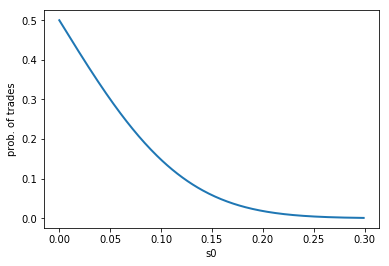

In [37]:
dist = GaussianMixture()
dist.fit(np.array(z).reshape(-1,1))
S = np.arange(0.0, 0.3, 0.001)
prob = 1-norm.cdf(S, scale=dist.covariances_[0][0][0]**0.5)
line, = plt.plot(S, prob, lw=2)
plt.ylabel("prob. of trades")
plt.xlabel("s0")
plt.show()

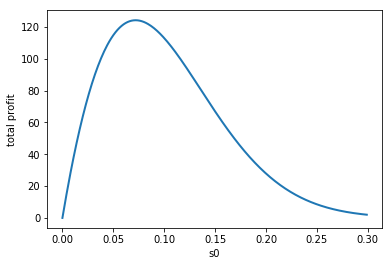

In [38]:
total_profit = S*len(prices_df["EUR"])*(prob)
line, = plt.plot(S, total_profit, lw=2)
plt.xlabel("s0")
plt.ylabel("total profit")
plt.show()

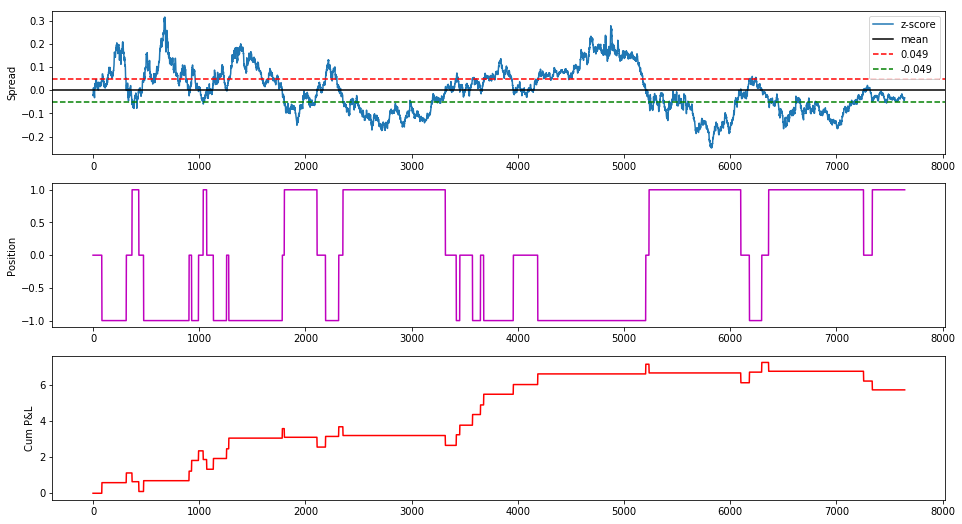

In [39]:
dist = GaussianMixture()
dist.fit(np.array(z).reshape(-1,1))
S = np.arange(0.0, 0.05, 0.001)
prob = 1-norm.cdf(S, scale=dist.covariances_[0][0][0]**0.5)
total_profit = S*len(prices_df["EUR"])*(prob)
s0 = S[np.argmax(total_profit)]

spread = -prices_df["EUR"] + prices_df["AUD"]*gamma
profit = [0]*len(z_zscore)
cum_profit = 0
position = [0]*len(z_zscore)
cur_pos = 0
z_zero_mean = z-u
for i in range(1, len(z_zscore)):
    
    if z_zero_mean[i]<-s0 and cur_pos==0:
        # buy spread
        cum_profit += spread[i]
        cur_pos = 1
    if z_zero_mean[i]>s0 and cur_pos==0:
        # short-sell spread
        cum_profit -= spread[i]
        cur_pos = -1
    if z_zero_mean[i]*z_zero_mean[i-1]<0 and cur_pos==-1: # zero-crossing
        cum_profit -= spread[i]
        cur_pos = 0
    if z_zero_mean[i]*z_zero_mean[i-1]<0 and cur_pos==1:
        cum_profit += spread[i]
        cur_pos = 0
    
        
    profit[i] = cum_profit
    position[i] = cur_pos

plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
plt.plot(z_zero_mean)
plt.axhline(z_zero_mean.mean(), color="black")
plt.axhline(s0, color="red", linestyle="--")
plt.axhline(-s0, color="green", linestyle="--")
plt.legend(["z-score", "mean", "{}".format(s0), "{}".format(-s0)])
plt.ylabel("Spread")

plt.subplot(3,1,2)
plt.plot(position, "m")
plt.ylabel("Position")

plt.subplot(3,1,3)
plt.plot(profit, "r")
plt.ylabel("Cum P&L")
plt.show()

In [40]:
print("cumulative profit:", cum_profit)

cumulative profit: 5.733198496175971


# Kalman for pairs trading

In [63]:
transition_matrices = [[1, 0], [0, 1]]
observation_matrices = np.expand_dims(np.vstack([[prices_df["AUD"]], [np.ones(len(prices_df["AUD"]))]]).T, axis=1)
kf = KalmanFilter(transition_matrices = transition_matrices, observation_matrices = observation_matrices)
measurements = np.asarray(prices_df["AUD"]).reshape(-1,1)
kf = kf.em(measurements, n_iter=5)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
# (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [88]:
gamma_kalman = filtered_state_means[:,0]
u_kalman = filtered_state_means[:,1]

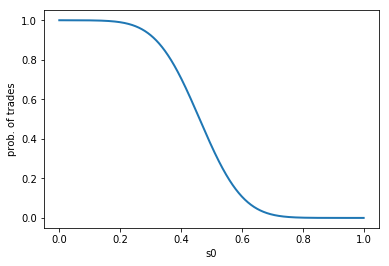

In [84]:
dist = GaussianMixture()
z = prices_df["EUR"] - prices_df["AUD"]*gamma_kalman
dist.fit(np.array(z).reshape(-1,1))
S = np.arange(0.0, 1, 0.001)
prob = 1-norm.cdf(S, loc=z.mean(), scale=dist.covariances_[0][0][0]**0.5)
line, = plt.plot(S, prob, lw=2)
plt.ylabel("prob. of trades")
plt.xlabel("s0")
plt.show()

In [93]:
spread = -prices_df["EUR"] + prices_df["AUD"]*u_kalman
z = prices_df["EUR"] - prices_df["AUD"]*u_kalman
z_zero_mean = z-gamma_kalman

In [101]:
u_kalman

array([4.69530192e-01, 4.71275589e-01, 4.72543668e-01, ...,
       1.73062402e-17, 1.73062402e-17, 1.73062402e-17])

In [106]:
z = prices_df["EUR"] - prices_df["AUD"]*gamma_kalman

In [107]:
z

0       0.904883
1       0.899162
2       0.913614
3       0.922782
4       0.931784
5       0.921100
6       0.919862
7       0.917850
8       0.921460
9       0.911768
10      0.907861
11      0.913337
12      0.898936
13      0.897018
14      0.889720
15      0.903402
16      0.913280
17      0.907178
18      0.902311
19      0.916386
20      0.912747
21      0.901031
22      0.903456
23      0.896706
24      0.910852
25      0.921306
26      0.922332
27      0.911209
28      0.908254
29      0.912731
          ...   
7613    0.434200
7614    0.437200
7615    0.444300
7616    0.442400
7617    0.440600
7618    0.439300
7619    0.436600
7620    0.435300
7621    0.433600
7622    0.431500
7623    0.424400
7624    0.426300
7625    0.424500
7626    0.424600
7627    0.428200
7628    0.429400
7629    0.427500
7630    0.425000
7631    0.422400
7632    0.419200
7633    0.420300
7634    0.418400
7635    0.417900
7636    0.417800
7637    0.414900
7638    0.416600
7639    0.418800
7640    0.4217

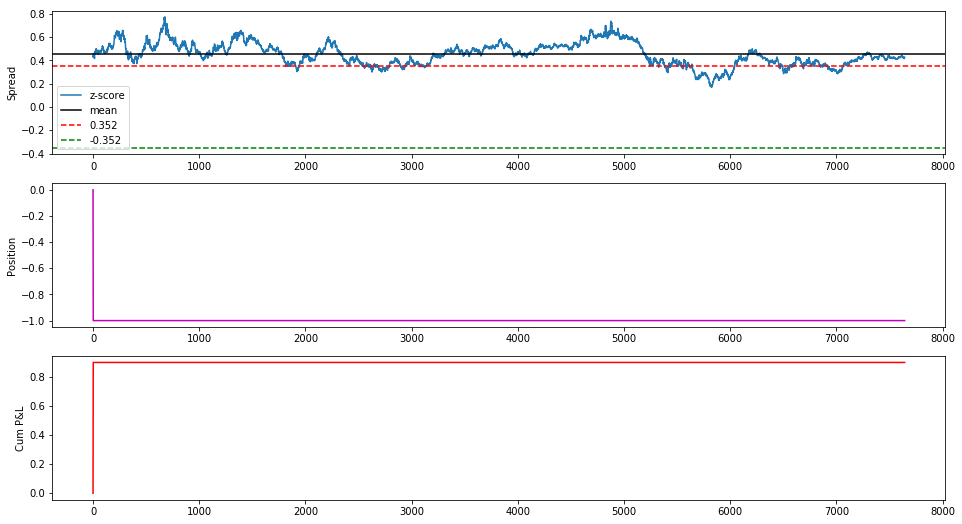

In [108]:
spread = -prices_df["EUR"] + prices_df["AUD"]*gamma_kalman
z = prices_df["EUR"] - prices_df["AUD"]*gamma_kalman
z_zero_mean = z-u_kalman 

dist = GaussianMixture()
dist.fit(np.array(z_zero_mean).reshape(-1,1))
S = np.arange(0.0, 1, 0.001)
prob = 1-norm.cdf(S, loc=dist.means_[0][0], scale=dist.covariances_[0][0][0]**0.5)
total_profit = S*len(prices_df["EUR"])*(prob)
s0 = S[np.argmax(total_profit)]

profit = [0]*len(z)
cum_profit = 0
position = [0]*len(z)
cur_pos = 0

for i in range(1, len(z)):
    
    if z_zero_mean[i]<-s0 and cur_pos==0:
        # buy spread
        cum_profit += spread[i]
        cur_pos = 1
    if z_zero_mean[i]>s0 and cur_pos==0:
        # short-sell spread
        cum_profit -= spread[i]
        cur_pos = -1
    if z_zero_mean[i]*z_zero_mean[i-1]<0 and cur_pos==-1: # zero-crossing
        cum_profit -= spread[i]
        cur_pos = 0
    if z_zero_mean[i]*z_zero_mean[i-1]<0 and cur_pos==1:
        cum_profit += spread[i]
        cur_pos = 0
    
        
    profit[i] = cum_profit
    position[i] = cur_pos

plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
plt.plot(z_zero_mean)
plt.axhline(z_zero_mean.mean(), color="black")
plt.axhline(s0, color="red", linestyle="--")
plt.axhline(-s0, color="green", linestyle="--")
plt.legend(["z-score", "mean", "{}".format(s0), "{}".format(-s0)])
plt.ylabel("Spread")

plt.subplot(3,1,2)
plt.plot(position, "m")
plt.ylabel("Position")

plt.subplot(3,1,3)
plt.plot(profit, "r")
plt.ylabel("Cum P&L")
plt.show()